# Sums of Kronecker terms

In some instances a single Kronecker term will not be enough to model a set of correlated Gaussian processes. A star, for instance, may exhibit variability on timescales of days due to rotational modulation and variability on timescales of minutes to hours due to surface convection. We would expect the rotationally modulated variability to have a different spectrum than the convectiondriven variability. To model this situation we therefore need two Kronecker terms, one to model the wavelength-dependence of the rotationally modulated variability and the other for the convection driven variability. 

In this tutorial we will construct a GP model for this situation and use it to simulate a stellar light curve. In the tutorial on modeling SOHO observations, we use a similar model to fit SOHO's three-channel sunphotometer data. 

To start, we'll define two ``celerite`` terms with different characteristic frequencies. 

In [1]:
import numpy as np
import exoplanet as xo

term1 = xo.gp.terms.SHOTerm(log_S0=-3.0, log_w0=2.0, log_Q=-np.log(np.sqrt(2)))
term2 = xo.gp.terms.SHOTerm(log_S0=5.0, log_w0=-1.0, log_Q=-np.log(np.sqrt(2)))

We can combine these with two different scaling vectors using ``specgp`` and define a GP from the resulting kernel:

In [2]:
from SpecGP.terms import KroneckerTerm
from SpecGP.means import KroneckerConstant

kronterm1 = KroneckerTerm(term1, [1, 3, 5])
kronterm2 = KroneckerTerm(term2, [5, 3, 1])

kernel = kronterm1 + kronterm2

t = np.linspace(0, 10, 1000)
gp = xo.gp.GP(x=t, kernel=kernel, diag=0.001 * np.ones((3, len(t))), mean=KroneckerConstant([0, 0]), J=4)

Now let's take a look at a random realization of the GP:

Text(0.5, 0, 'time')

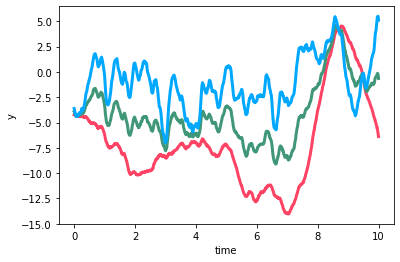

In [3]:
import matplotlib.pyplot as pl
%matplotlib inline

n = np.random.randn(3*len(t), 1)
y = gp.dot_l(n).eval()

pl.plot(t, y[::3], color='#FE4365', linewidth=3)
pl.plot(t, y[1::3], color='#3F9778', linewidth=3)
pl.plot(t, y[2::3], color='#00A9FF', linewidth=3)
pl.ylabel('y')
pl.xlabel('time')

We can clearly see two different timescales of variability and that they have different wavelength-dependencies. On long timescales the amplitude of the variability increase as we go from the blue to the green to the red curve, but on short timescales the opposite is true. This behavior cannot be captured by a single ``KroneckerTerm``. 

Another case in which one may want to combine multiple ``KroneckerTerms`` is the case in which two processes share a common source of variability but also have their own independent variabilities. For instance, two stars that are observed at the same time via the same instrument will have the same systematics, but with their own variability superimposed. Let's see how we can reproduct this situation using a sum of ``KroneckerTerms``. We begin by defining ``celerite`` terms for the common variability and each of the independent processes:

In [4]:
common_term = xo.gp.terms.SHOTerm(log_S0=10.0, log_w0=-2.0, log_Q=-np.log(np.sqrt(2)))
ind_term1 = xo.gp.terms.SHOTerm(log_S0=-2.0, log_w0=2.0, log_Q=-np.log(np.sqrt(2)))
ind_term2 = xo.gp.terms.SHOTerm(log_S0=-2.0, log_w0=2.0, log_Q=-np.log(np.sqrt(2)))

If we want the common term to have the same amplitude at each wavelength, then the scaling vector should be ``[1, 1]``. For the independent terms, the scaling vectors will be ``[1, 0]`` and ``[0, 1]`` so that the amplitude of the unwanted term is zero'd out for each time series:

In [5]:
common_alpha = [1, 1]
ind_alpha1 = [1, 0]
ind_alpha2 = [0, 1]

kernel = (KroneckerTerm(common_term, common_alpha) + 
          KroneckerTerm(ind_term1, ind_alpha1) + 
          KroneckerTerm(ind_term2, ind_alpha2))

We define a GP with this kernel, this time setting J=6 (J increases by 2 for each SHOTerm).

In [6]:
gp = xo.gp.GP(x=t, 
              kernel=kernel, 
              diag=0.001 * np.ones((2, len(t))), 
              mean=KroneckerConstant([0, 0]), 
              J=6)

As before we can get an idea of what the GP is doing by looking at a random realization:

Text(0.5, 0, 'time')

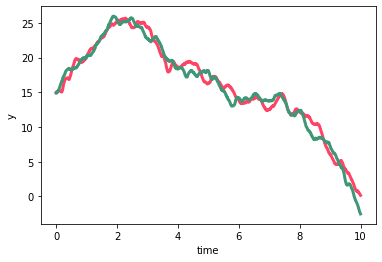

In [7]:
n = np.random.randn(2*len(t), 1)
y = gp.dot_l(n).eval()

pl.plot(t, y[::2], color='#FE4365', linewidth=3)
pl.plot(t, y[1::2], color='#3F9778', linewidth=3)
pl.ylabel('y')
pl.xlabel('time')

And, as constructed, we see that the two timeseries share the long-timescale, large-amplitude variability while the shorter timescale lower amplitude variability is unique to each timeseries.